## Sentiment Analysis Models using Bag-of-Words

Previously downloaded and processed movie review data from IMDB.  Code calls these functions, it prepares the positive and negative reviews from the training dataset.   At the end of this process we have the processed reviews and the associated labels for each review. 

In [55]:
import string
import re
from os import listdir
from numpy import array
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
import os
from IPython.display import Image
os.environ["PATH"] += os.pathsep +  'C:\\Users/richard\\Anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz'

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
    
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# load and clean a dataset
def load_clean_dataset(vocab, is_train=1):
    # load documents
    neg = process_docs('data/txt_sentoken/neg', vocab, is_train)
    pos = process_docs('data/txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
    return docs, labels


Use Tokenizer class that can do some cleaning and vocab definition tasks. First, the Tokenizer must be created, then fit on the text documents
in the training dataset. In this case, these are the aggregation of the positive lines and
negative lines arrays developed in the previous section

In [22]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [23]:
#load the vocab
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
#get the processed vocabulary from the reviews
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
print(len(vocab))

14803


In [24]:
#can see the train docs is lost of strings of the reviews, ytrain are the labels for each of the strings here both negative
#print(train_docs[0],"\n\n",ytrain[0])

In [25]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [26]:
#look at some of the methods
print(dir(tokenizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'index_docs', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 'split', 'texts_to_matrix', 'texts_to_sequences', 'texts_to_sequences_generator', 'word_counts', 'word_docs', 'word_index']


In [27]:
#get some values
#print(tokenizer.word_counts)
print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)

1800


In [28]:
#encode the data using text to matrix
print(help(tokenizer.texts_to_matrix))

Help on method texts_to_matrix in module keras.preprocessing.text:

texts_to_matrix(texts, mode='binary') method of keras.preprocessing.text.Tokenizer instance
    Convert a list of texts to a Numpy matrix.
    
    # Arguments
        texts: list of strings.
        mode: one of "binary", "count", "tfidf", "freq".
    
    # Returns
        A Numpy matrix.

None


In [29]:
#encode the data
Xtrain = tokenizer.texts_to_matrix(train_docs,mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs,mode='freq')
print(Xtrain.shape,Xtest.shape)

(1800, 14781) (200, 14781)


### Develop Model
Develope a MLP model to predict the sentiment of the encoded reviews.  Size of the input layer will equal number of words in the vocab above

In [30]:
n_words = Xtest.shape[1]
n_words

14781

Try trial and error selction of model. Use a single hidden layer
with 60 neurons and a rectified linear activation function. Output layer is a single neuron
with a sigmoid activation function for predicting 0 for negative and 1 for positive reviews. The
network will be trained using the efficient Adam implementation of gradient descent and the
binary cross entropy loss function, suited to binary classification problems.

In [34]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(60, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='img/model.png', show_shapes=True)
    return model

In [35]:
model = define_model(n_words)
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 60)                886920    
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 61        
Total params: 886,981
Trainable params: 886,981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 2s - loss: 0.6915 - acc: 0.6161
Epoch 2/10
 - 1s - loss: 0.6804 - acc: 0.7756
Epoch 3/10
 - 1s - loss: 0.6554 - acc: 0.8556
Epoch 4/10
 - 1s - loss: 0.6161 - acc: 0.9183
Epoch 5/10
 - 1s - loss: 0.5667 - acc: 0.9261
Epoch 6/10
 - 1s - loss: 0.5129 - acc: 0.9350
Epoch 7/10
 - 1s - loss: 0.4595 - acc: 0.9417
Epoch 8/10
 - 1s - loss: 0.4093 - acc: 0.9478
Epoch 9/10
 - 1s - loss: 0.3623 - acc: 0.9572
Epoch 10/10
 - 1s - loss: 0.3207 - acc: 0.9639
Test Accuracy: 88.000000


Accuracy of 87% on the test data

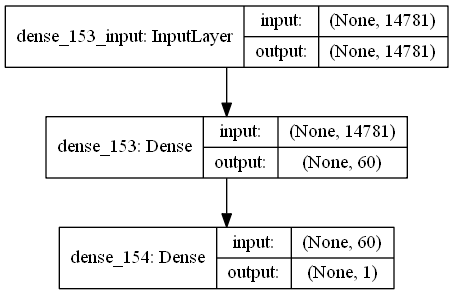

In [36]:
Image("img/model.png",width = 400)

### Comparing the word scoring methods

The texts to matrix() function for the Tokenizer in the Keras API provides 4 different
methods for scoring words:
- binary Where words are marked as present (1) or absent (0).
- count Where the occurrence count for each word is marked as an integer.
- tfidf Where each word is scored based on their frequency, where words that are common across all documents are penalized.
- freq Where words are scored based on their frequency of occurrence within the document.

Try to evaluate the skill of the model developed in the previous section fit using each of the
4 supported word scoring modes. This first involves the development of a function to create an
encoding of the loaded documents based on a chosen scoring model. The function creates the
tokenizer, fits it on the training documents, then creates the train and test encodings using the
chosen model. The function prepare data() implements this behavior given lists of train and
test documents.

In [16]:
def prepare_data(train_docs,test_docs,mode):
    #create tokenizer
    tokenizer = Tokenizer()
    #fit the tokenizer
    tokenizer.fit_on_texts(train_docs)
    #encode the training data
    Xtrain = tokenizer.texts_to_matrix(train_docs,mode=mode)
    # encode training data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest  

As neural networks are stochastic, they can produce different results when the same model is fit on
the same data, because of the random initial weights and the shuffling of patterns
during mini-batch gradient descent. This means that any one scoring of a model is unreliable
and we should estimate model skill based on an average of multiple runs. Function below takes encoded documents and evaluates the MLP by training it on
the train set and estimating skill on the test set 10 times and returns a list of the accuracy
scores across all of these runs.

In [19]:
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 10
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # compile network
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit network
        model.fit(Xtrain, ytrain, epochs=5, verbose=0)
        # evaluate
        loss, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

In [20]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
    # summarize results
    #print(results.describe())
    # plot results
    #results.boxplot()
    #pyplot.show()

1 accuracy: 0.925
2 accuracy: 0.925
3 accuracy: 0.94
4 accuracy: 0.935
5 accuracy: 0.925
6 accuracy: 0.94
7 accuracy: 0.925
8 accuracy: 0.935
9 accuracy: 0.925
10 accuracy: 0.93
1 accuracy: 0.895
2 accuracy: 0.905
3 accuracy: 0.895
4 accuracy: 0.895
5 accuracy: 0.905
6 accuracy: 0.89
7 accuracy: 0.895
8 accuracy: 0.88
9 accuracy: 0.91
10 accuracy: 0.895
1 accuracy: 0.855
2 accuracy: 0.865
3 accuracy: 0.89
4 accuracy: 0.875
5 accuracy: 0.88
6 accuracy: 0.89
7 accuracy: 0.885
8 accuracy: 0.875
9 accuracy: 0.875
10 accuracy: 0.885
1 accuracy: 0.85
2 accuracy: 0.825
3 accuracy: 0.83
4 accuracy: 0.865
5 accuracy: 0.81
6 accuracy: 0.825
7 accuracy: 0.855
8 accuracy: 0.86
9 accuracy: 0.865
10 accuracy: 0.835


Text(0,0.5,'Accuracy')

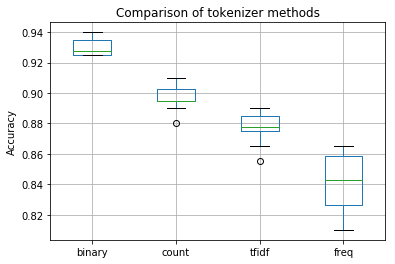

In [39]:
results.boxplot()
pyplot.title('Comparison of tokenizer methods')
pyplot.ylabel('Accuracy')

In [41]:
#pandas summary of data
print(results.describe())

          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.930500   0.896500   0.877500   0.842000
std     0.006433   0.008515   0.011118   0.019465
min     0.925000   0.880000   0.855000   0.810000
25%     0.925000   0.895000   0.875000   0.826250
50%     0.927500   0.895000   0.877500   0.842500
75%     0.935000   0.902500   0.885000   0.858750
max     0.940000   0.910000   0.890000   0.865000


Binary results in best accuracy and simplest spread

### Predicting Sentiment for New Reviews

Develop and use a final model to make predictions for new textual reviews.  First train a final model on all of the
available data. We will use the binary mode for scoring the bag-of-words model that was shown
to give the best results in the previous section.

Predicting the sentiment of new reviews involves following the same steps used to prepare
the test data. Specifically, loading the text, cleaning the document, filtering tokens by the
chosen vocabulary, converting the remaining tokens to a line, encoding it using the Tokenizer,
and making a prediction. We can make a prediction of a class value directly with the fit model
by calling predict() that will return an integer of 0 for a negative review and 1 for a positive
review. 

All of these steps can be put into a new function called predict sentiment() that
requires the review text, the vocabulary, the tokenizer, and the fit model and returns the
predicted sentiment and an associated percentage or confidence-like output.

In [52]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    #print(line)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    # predict sentiment
    yhat = model.predict(encoded, verbose=0)
    #print(yhat)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]

    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

Make predictions for new movie texts

In [57]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab)
test_docs, ytest = load_clean_dataset(vocab)

# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')

# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)

# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
print('\n')
# test positive text
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 60)                886920    
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 61        
Total params: 886,981
Trainable params: 886,981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 2s - loss: 0.4673 - acc: 0.7728
Epoch 2/10
 - 1s - loss: 0.0664 - acc: 0.9911
Epoch 3/10
 - 0s - loss: 0.0172 - acc: 1.0000
Epoch 4/10
 - 0s - loss: 0.0076 - acc: 1.0000
Epoch 5/10
 - 1s - loss: 0.0042 - acc: 1.0000
Epoch 6/10
 - 1s - loss: 0.0026 - acc: 1.0000
Epoch 7/10
 - 1s - loss: 0.0017 - acc: 1.0000
Epoch 8/10
 - 1s - loss: 0.0012 - acc: 1.0000
Epoch 9/10
 - 0s - loss: 8.1990e-04 - acc: 1.0000
Epoch 10/10
 - 1s - loss: 6.0387e-04 - acc: 1.0000


Review: [Best movie ever! It was great, I recommend it.]
Sent